# Chapter 3: Classification

This notebook covers chapter 3 of the book on the topic of classification. The prior chapter covered a regression ML project.

## Setup

Provide useful imports that will be valuable in the project.

In [1]:
import numpy as np

## MNIST

Download and play with MNIST data.

In [2]:
from sklearn.datasets import fetch_openml

# Setting `as_frame` to False to avoid the result being returned as a Pandas DataFrame (what would happen otherwise).
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Let's try to draw one of these.

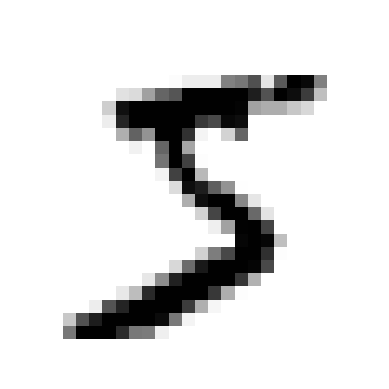

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

This shows that the number is indeed a 5 (as it looks like). However, the labels are stored as strings. Let's recast to an integer for the purpose of the ML algorithms.

In [6]:
y = y.astype(np.uint8)

Okay, now the results are (unsigned) integers.

In [7]:
y[0]

5

Let's separate data out into test and train sets.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Trying out the classifier on a few values.

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
sgd_clf.predict([X[0], X[1], X[2]])

array([ True, False, False])

In [14]:
y[0], y[1], y[2]

(5, 0, 4)

## Implementing Cross-Validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
from sklearn.base import BaseEstimator

# Well, we could just as well call this NeverWhatYouArePredictingClassifier. The 5 is just
# an artifact of the fact we're trying to predict when the number is 5.
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
# What the confusion matrix would look like with perfect predictions.
y_train_perfect = y_train_5
confusion_matrix(y_train_5, y_train_perfect)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [33]:
from sklearn.metrics import precision_score, recall_score
print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311


In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [12]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [14]:
threshold = 0
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

array([ True])

Let's use a higher threshold.

In [16]:
threshold = 8000
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

array([False])

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Use Matplotlib to plot precision and recall as functions of the threshold value.

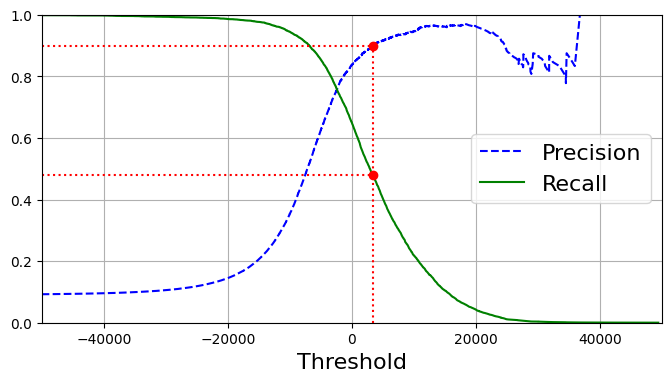

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    # highlight the threshold and add the legend, axis label, and grid
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
    
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

In [31]:
print("Threshold that achieves >= 90% precision:", threshold_90_precision)

Threshold that achieves >= 90% precision: 3370.0194991439557


In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

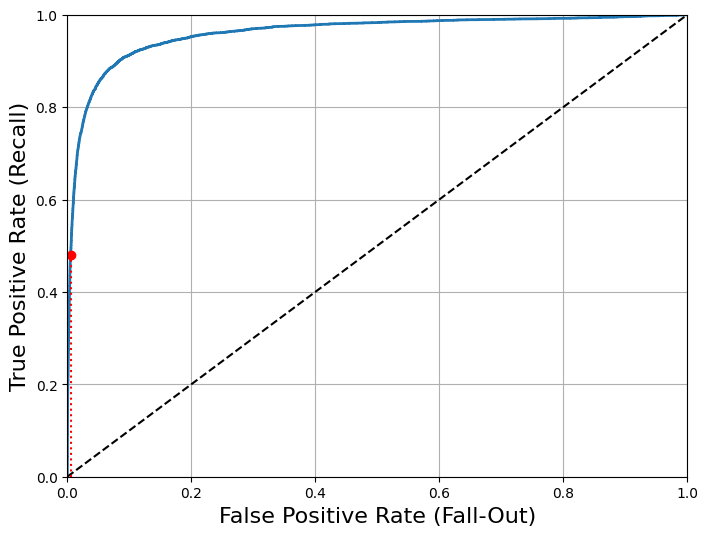

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal.
    # Add axis labels and grid
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()
